In [ ]:
# Cell 1 - Imports
import opendatasets as od

import torch
import torch.nn as nn 
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision.utils import save_image
import wandb
import matplotlib.pyplot as plt
import os
wandb.init(project='anime-dcgan')

Imports Python libraries needed for the project like PyTorch for neural networks. Initializes logging to WandB for tracking experiments.

In [ ]:
# Cell 2 - Load data
dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

DATA_DIR = 'animefacedataset/'

image_size = 64
batch_size = 128
latent_size = 128
wandb.log({'batch_size': batch_size, 'latent_size': latent_size})
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
device = 'cuda'

train_ds = ImageFolder(DATA_DIR, transform=T.Compose([T.Resize(image_size), T.CenterCrop(image_size), T.ToTensor(), T.Normalize(*stats)]))
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 16, pin_memory = True)

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

Downloads the anime face image dataset from Kaggle. Defines hyperparameters like batch size and image dimensions. Loads the images and normalizes them to feed into the neural networks later.



In [3]:
# Cell 3 - Define model classes

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

discriminator = torch.compile(Discriminator()).to(device)


class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

generator = torch.compile(Generator()).to(device)

Defines the discriminator and generator neural network models as PyTorch classes, inheriting from nn.Module. The models are sequences of convolutional and transpose convolutional layers.

In [4]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score


def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

Training functions that loop through batches of real and fake images, calculate loss, and update model weights. Discriminator tries to classify real vs fake, generator tries to fool discriminator.

In [ ]:

sample_dir = 'saved_images/'

def save_samples(index, latent_tensors, show=True):
    from PIL import Image
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    img = Image.open(os.path.join(sample_dir, fake_fname))
    wandb.log({"generated_images": [wandb.Image(img, caption=f"generated_images-{index}")]})
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

fixed_latent = torch.randn(image_size, latent_size, 1, 1, device=device)

Generates fake images from the generator by passing in random noise. Saves some generated samples to check progress.

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in train_dl:
            # Train discriminator
            real_images = real_images.to(device)
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        wandb.log({"loss_g": loss_g, "loss_d": loss_d, "real_score": real_score, "fake_score": fake_score})
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    # wandb log metrics
    return losses_g, losses_d, real_scores, fake_scores

lr = 2e-4
epochs = 100

history = fit(epochs, lr)

Main training loop that runs for multiple epochs. Alternates between training discriminator and generator. Logs losses and saves model checkpoints.



In [6]:

torch.save(generator.state_dict(), 'G2.pth')
torch.save(discriminator.state_dict(), 'D2.pth')

Saves the final trained generator and discriminator models to files.

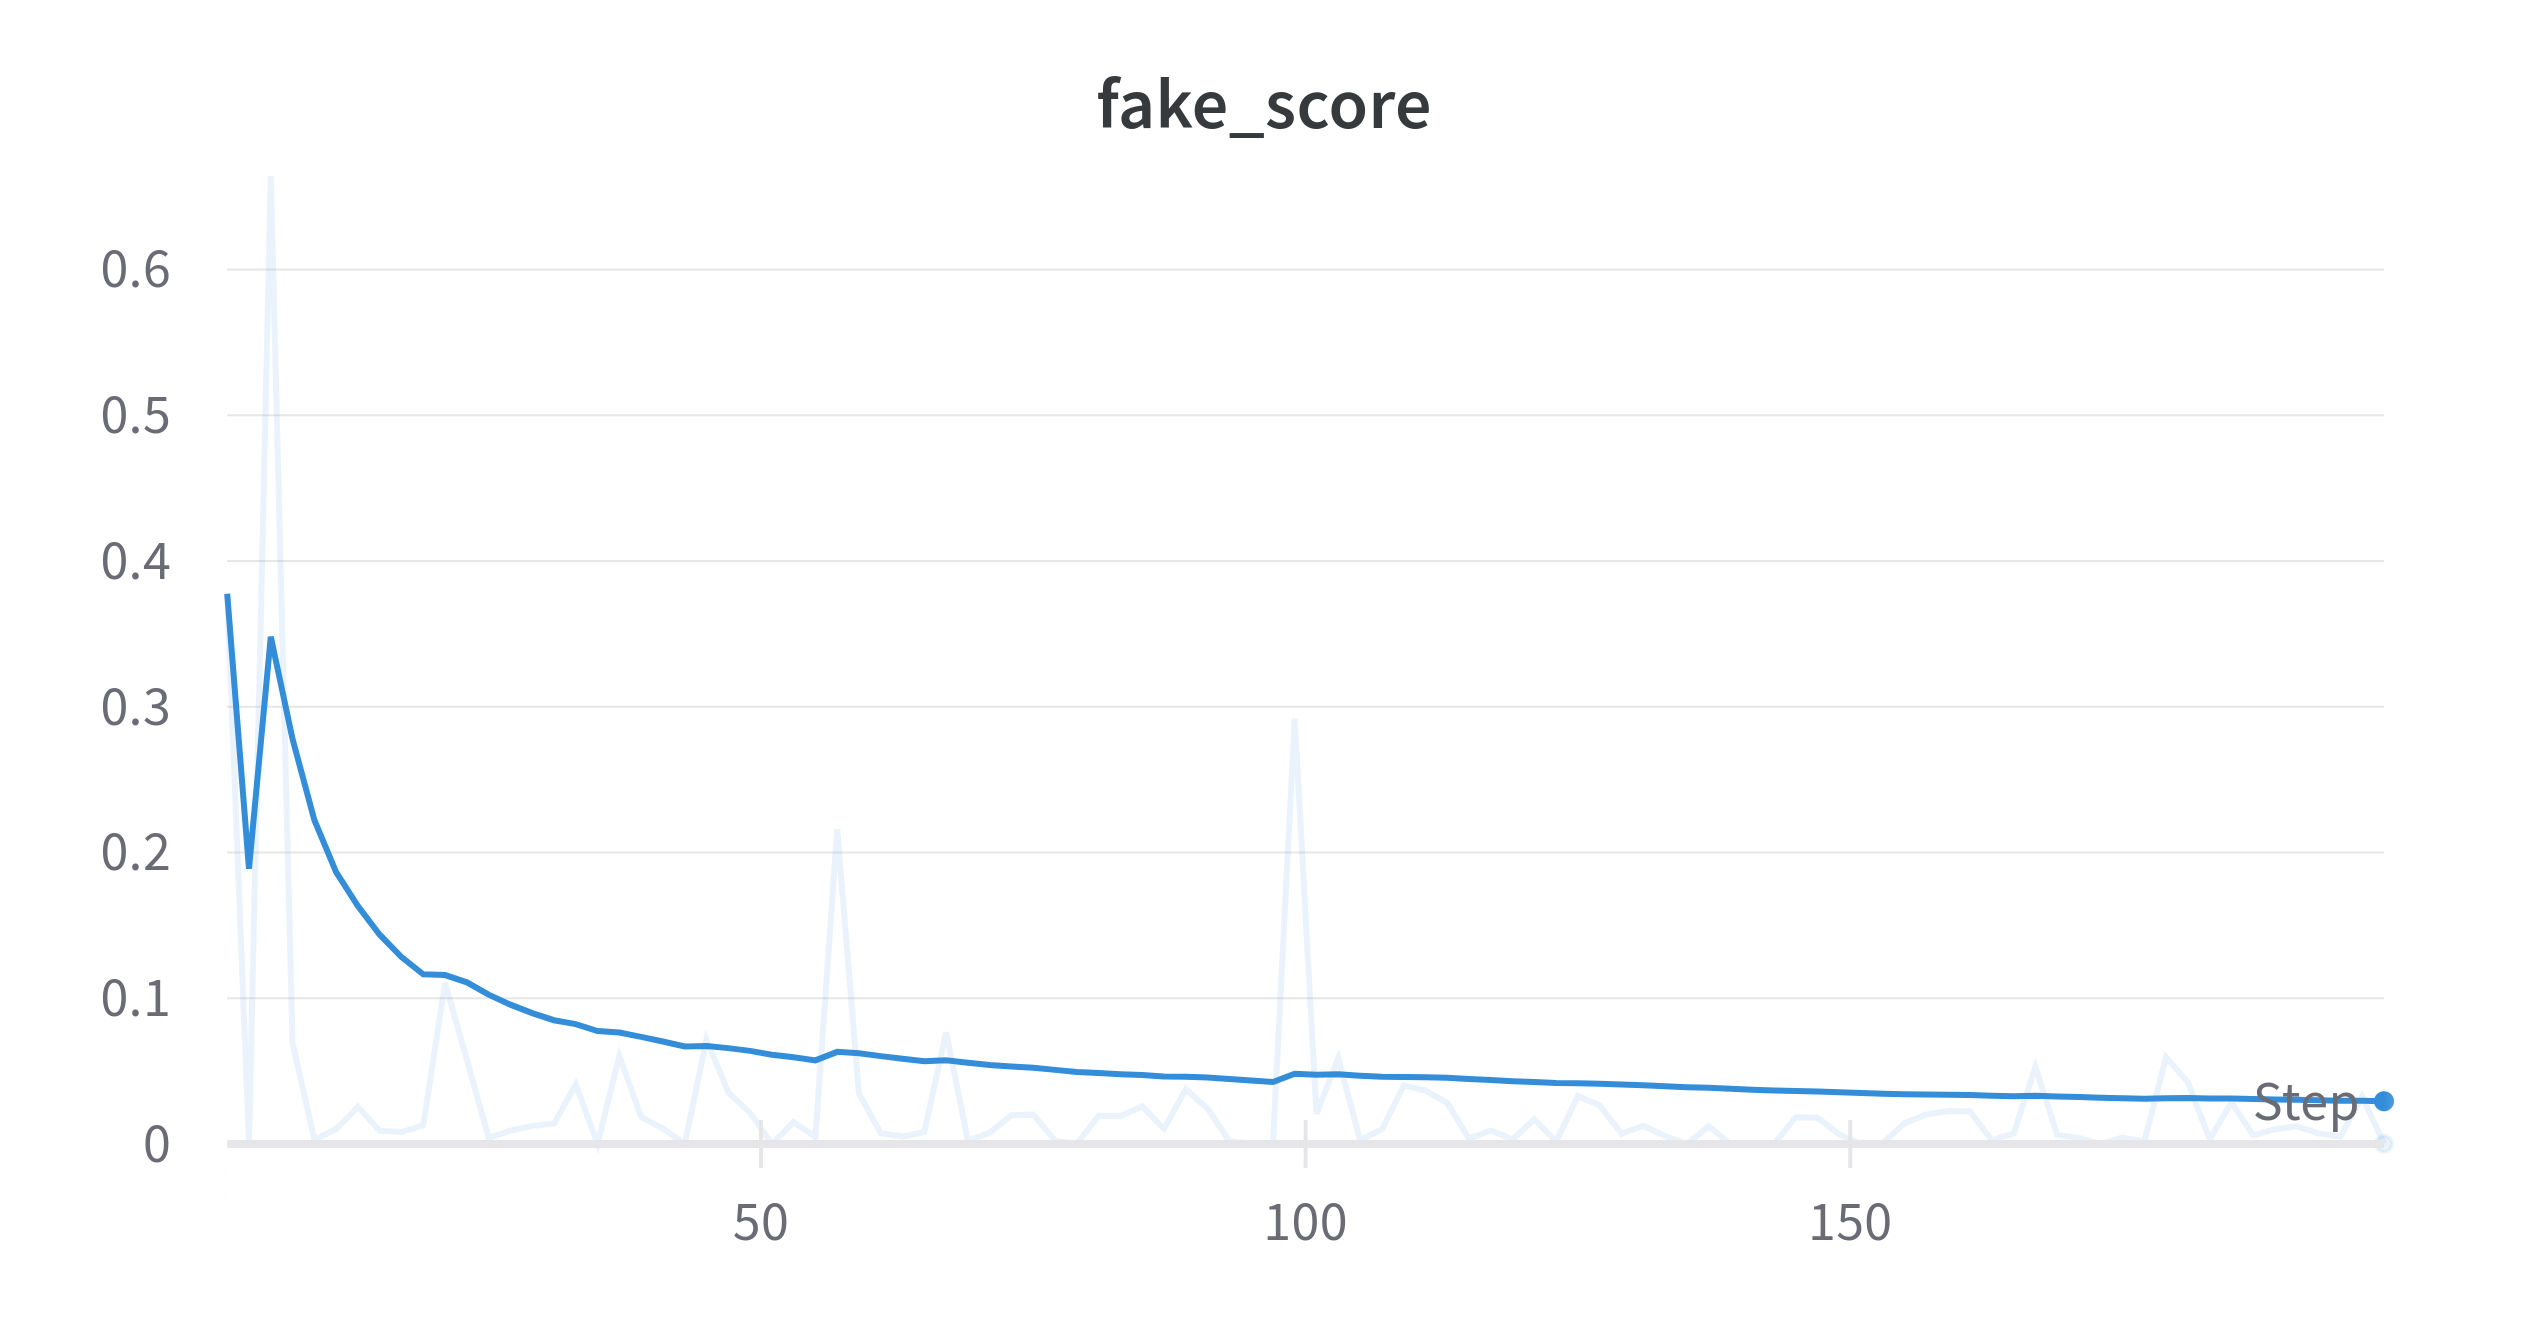

In [7]:
from IPython.display import Image
Image("fake.png")

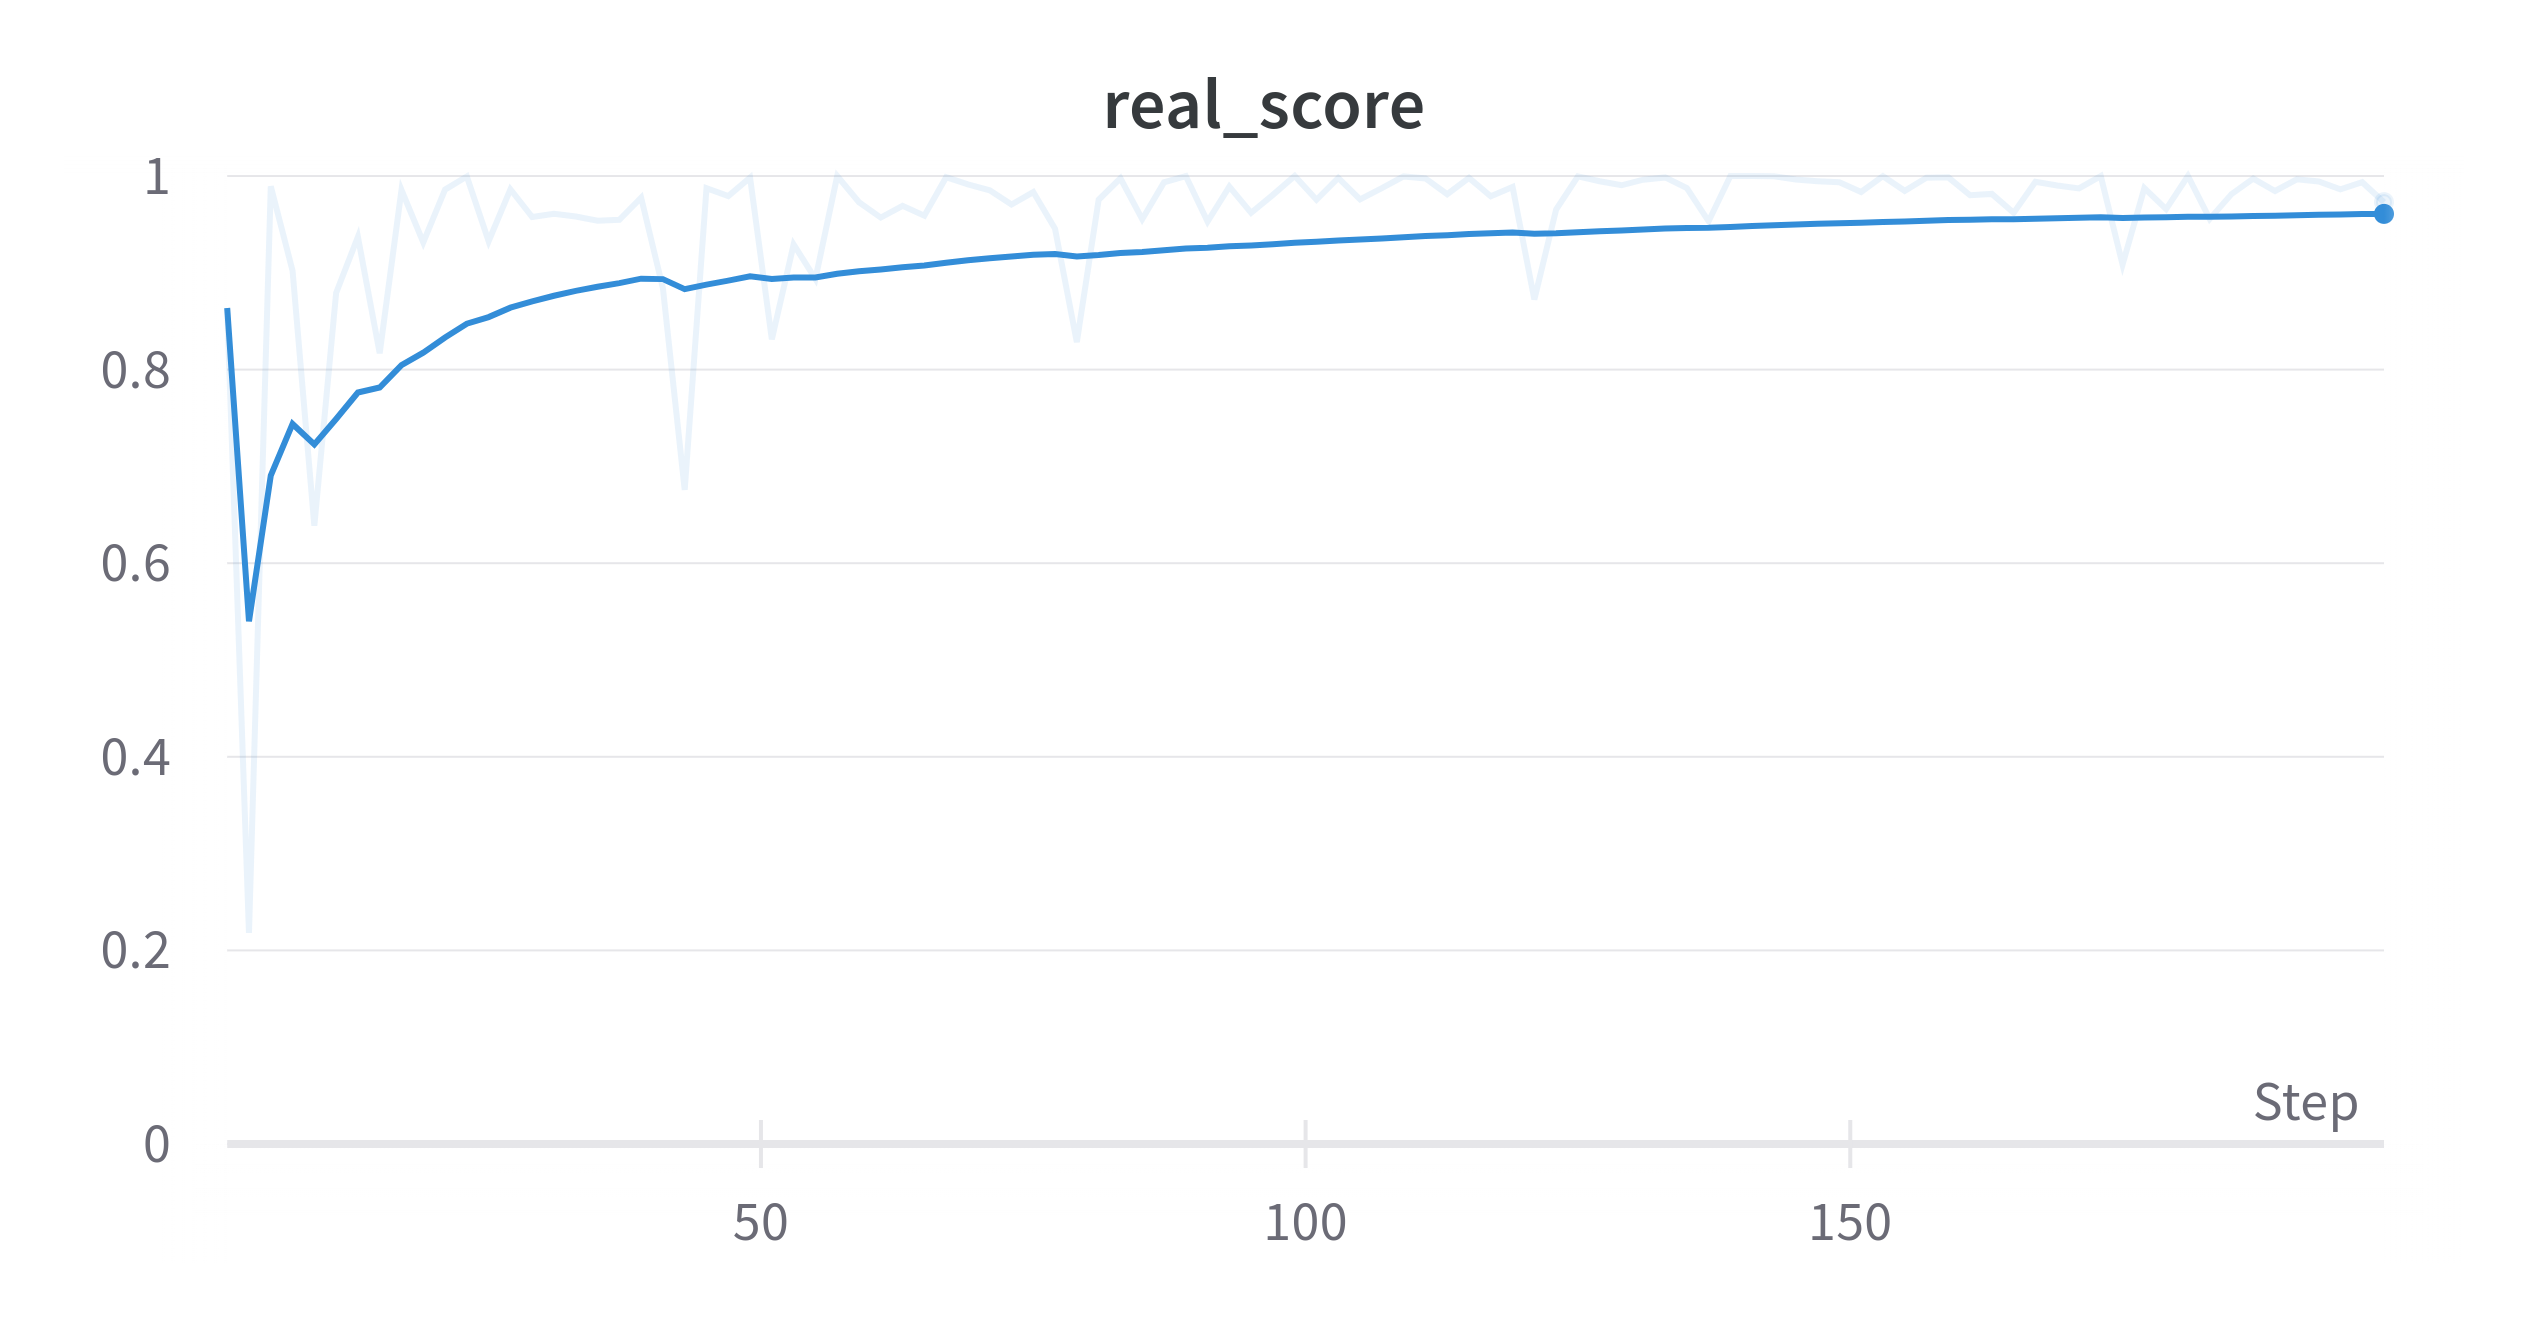

In [8]:
Image("real.png")

 - The real_score reflects the discriminator's accuracy at classifying real images as real. We want this to approach 1.0, meaning it perfectly identifies real images.
 - The fake_score reflects the discriminator's accuracy at classifying fake images (generated by the generator) as fake. We want this to approach 0.0, meaning it identifies fake images as fake.

Initially, the discriminator is untrained so its real_score and fake_score will both start around 0.5, meaning it is randomly guessing.
As training progresses, the discriminator gets better at telling real vs fake images apart. The real_score increases towards 1.0, and the fake_score decreases towards 0.0.

The generator is also being trained to try and fool the discriminator. As the generator gets better, it generates more realistic fake images. This causes the discriminator's fake_score to start increasing again.

So in summary, the real_score and fake_score metrics move in opposition because the discriminator and generator are playing a tug-of-war game during training - the discriminator trying to tell apart real vs. fake, and the generator trying to trick the discriminator. Their training progresses are coupled which leads to the observed relationship between the scores.